In [1]:
import re
import pandas as pd
import nltk
import numpy as np
import pycountry
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import DBSCAN
from collections import Counter, defaultdict

# Download 'stopwords' corpus
#nltk.download('stopwords')

In [2]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns

In [4]:
#file_path1 = '/Users/manaswimondol/Desktop/Jupyter Notebooks/paper90_set.xlsx'
#Change it when you run it on your laptop
file_path1 = '/Users/manaswimondol/Desktop/Jupyter Notebooks/Paper_WoS.xlsx'
df = pd.read_excel(file_path1)
df = df.drop_duplicates()
df = df.dropna(subset=['abstract'])
df = df.dropna(subset=['keywords'])
#print the columns of the DataFrame
print(df.columns)
#df.info()
df.describe()

Index(['ID', 'MDMM', 'source', 'pubID', 'pubyear', 'authorfull', 'title',
       'score', 'abstract', 'comment', 'Objective Time use measures?',
       'Devices?', 'RELEVANT_FINDINGS', 'keywords', 'keywordsplus', 'auaffil',
       'timescited_woscomplete', 'sthits', 'mdkeywords', 'searchid', 'net_cl',
       'keyword_cl', 'keyword_cl_size', 'academi', 'screen use', 'phone use',
       'screen', 'track', 'activit', 'screen time', 'detox', 'donat',
       'digital', 'attention', 'media', 'device', 'smartphone'],
      dtype='object')


,ID,MDMM,pubyear,score,timescited_woscomplete,sthits,keyword_cl_size,academi,screen use,phone use,...,track,activit,screen time,detox,donat,digital,attention,media,device,smartphone
count,6478.000000,6478.000000,6478.000000,81.000000,6478.000000,6478.000000,6478.000000,55.0,6478.000000,6478.000000,...,6478.000000,6478.000000,5413.000000,5413.000000,5413.000000,5413.000000,5413.000000,5413.000000,5413.000000,5413.000000
mean,9549.790676,0.098024,2018.748070,4.432099,28.572399,2.120562,3728.280025,1.0,0.022229,0.245755,...,28.672738,0.254863,0.253464,0.003325,0.001478,0.122483,0.091077,0.531683,0.118234,0.247183
std,4653.909315,0.297370,3.431836,3.632968,58.596707,1.201540,1882.935731,0.0,0.147439,0.430567,...,80.162258,0.435818,0.435034,0.057575,0.038419,0.327873,0.287745,0.499041,0.322915,0.431414
min,45.000000,0.000000,2001.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5596.500000,0.000000,2016.000000,0.000000,2.000000,1.000000,3632.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9697.000000,0.000000,2020.000000,5.000000,10.000000,2.000000,3632.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,13039.750000,0.000000,2021.000000,8.000000,32.000000,3.000000,5271.000000,1.0,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,17887.000000,1.000000,2023.000000,10.000000,1383.000000,7.000000,5271.000000,1.0,1.000000,1.000000,...,397.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
columns_remove=['score','RELEVANT_FINDINGS','auaffil', 'sthits', 'searchid', 'net_cl','keyword_cl', 'keyword_cl_size', 'academi', 'screen use', 'phone use', 'screen', 'track', 'activit', 'screen time', 'detox', 'donat','digital', 'attention', 'media', 'device', 'smartphone']
df = df.drop(columns=columns_remove)
print(df.columns)
df.describe()

Index(['ID', 'MDMM', 'source', 'pubID', 'pubyear', 'authorfull', 'title',
       'abstract', 'comment', 'Objective Time use measures?', 'Devices?',
       'keywords', 'keywordsplus', 'timescited_woscomplete', 'mdkeywords'],
      dtype='object')


,ID,MDMM,pubyear,timescited_woscomplete
count,6478.000000,6478.000000,6478.000000,6478.000000
mean,9549.790676,0.098024,2018.748070,28.572399
std,4653.909315,0.297370,3.431836,58.596707
min,45.000000,0.000000,2001.000000,0.000000
25%,5596.500000,0.000000,2016.000000,2.000000
50%,9697.000000,0.000000,2020.000000,10.000000
75%,13039.750000,0.000000,2021.000000,32.000000
max,17887.000000,1.000000,2023.000000,1383.000000


In [6]:
#df.head()

In [7]:
# Convert to lowercase
# Remove special characters, numbers, and extra spaces
# Tokenization
# Remove stop words
# Stemming
# Join the tokens back into a single string


def preprocess_text(text):

    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    processed_text = ' '.join(tokens)
    
    return processed_text

df['processed_abstract'] = df['abstract'].apply(preprocess_text)

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['processed_abstract'])

# Convert the sparse matrix to a dense array 
dense_array = X.toarray()

# The 'dense_array' contains the TF-IDF representation of abstracts and is for training your machine learning model

In [8]:
dense_array.shape

(6478, 1000)

In [9]:
df.head()

,ID,MDMM,source,pubID,pubyear,authorfull,title,abstract,comment,Objective Time use measures?,Devices?,keywords,keywordsplus,timescited_woscomplete,mdkeywords,processed_abstract
0,69,0,TELEVISION & NEW MEDIA,CHARITSIS23,2023,"Charitsis, Vassilis | Lehtiniemi, Tuukka",Data Ableism: Ability Expectations and Margina...,While data is increasingly proffered as the re...,NaN,NaN,NaN,ableism; datafication; data norms; data coloni...,BIG DATA; SURVEILLANCE; DISABILITY; METAPHORS;...,3,digital;media,data increasingli proffer resourc unlock promi...
1,565,0,COMPUTERS IN HUMAN BEHAVIOR,MAHALINGHAM23,2023,"Mahalingham, Tamsin | McEvoy, Peter M. | Clark...",Assessing the validity of self-report social m...,Social media use research remains dominated by...,NaN,NaN,NaN,Social media; Problematic social media use; So...,NaN,0,media;phone use;smartphone,social media use research remain domin selfrep...
2,819,0,COMPUTERS IN HUMAN BEHAVIOR,ORR23,2023,"Orr, Matthew | MacLeod, Lucy | Bagnell, Alexa ...",The comfort of adolescent patients and their p...,To integrate mobile sensing and digital phenot...,NaN,NaN,NaN,Digital phenotyping; Mobile sensing; Youth; Pa...,BIPOLAR DISORDER; SMARTPHONE DATA; PRIVACY,0,digital,integr mobil sens digit phenotyp youth mental ...
3,1579,0,JOURNAL OF COMMUNICATION,CARTER23,2023,"Carter, Michael C. | Cingel, Drew P. | Ruiz, J...",Social media use in the context of the Persona...,The rapid proliferation and maturation of soci...,NaN,NaN,NaN,social media use; social media elements; Ecolo...,NaN,1,digital;media,rapid prolifer matur social media platform led...
4,2297,1,INTERNATIONAL JOURNAL OF HUMAN-COMPUTER STUDIES,SHI23,2023,"Shi, Yaoxi | Koval, Peter | Kostakos, Vassilis...",?Instant Happiness?: Smartphones as tools for ...,Smartphone use has become an indispensable asp...,NaN,NaN,NaN,Emotion regulation; Emotion; Smartphone; Exper...,COLLEGE-STUDENTS; MOBILE PHONES; SOCIAL NETWOR...,0,media;phone use;smartphone,smartphon use becom indispens aspect daili lif...


In [12]:
# Get a list of country names
country_list = [country.name for country in pycountry.countries]


new_C = 'Switzerland'
country_list.append(new_C)

# Print the list of country names
print(country_list)

survey_keywords = ['survey', 'data collection', 'questionnaire', 'interview']

objective_keywords = ['experiment', 'measurement', 'observational studies']

# Function to check if a country is mentioned in the abstract
def contains_country(abstract):
    return any(country.lower() in abstract.lower() for country in country_list)

# Function to check if survey-related keywords are present in the abstract
def contains_survey_keyword(abstract):
    return any(keyword.lower() in abstract.lower() for keyword in survey_keywords)

def mentioned_countries(abstract):
    mentioned = [country for country in country_list if country.lower() in abstract.lower()]
    return mentioned

def contains_objective_keywords(abstract):
    return any(keyword.lower() in abstract.lower() for keyword in objective_keywords)

# Apply the functions to create new columns
df['Contains_Country'] = df['abstract'].apply(contains_country)
df['Contains_Survey'] = df['abstract'].apply(contains_survey_keyword)
df['Mentioned_Countries'] = df['abstract'].apply(mentioned_countries)
df['Contains_Objective'] = df['abstract'].apply(contains_objective_keywords)



# Filter rows where a country is mentioned and data collection is done
filtered_df = df[(df['Contains_Country']) & (df['Contains_Survey'])]

# Display the filtered dataframe
filtered_df.head()

#display the dataframe with new columns 
df.head()

['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Åland Islands', 'Albania', 'Andorra', 'United Arab Emirates', 'Argentina', 'Armenia', 'American Samoa', 'Antarctica', 'French Southern Territories', 'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Bonaire, Sint Eustatius and Saba', 'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas', 'Bosnia and Herzegovina', 'Saint Barthélemy', 'Belarus', 'Belize', 'Bermuda', 'Bolivia, Plurinational State of', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan', 'Bouvet Island', 'Botswana', 'Central African Republic', 'Canada', 'Cocos (Keeling) Islands', 'Switzerland', 'Chile', 'China', "Côte d'Ivoire", 'Cameroon', 'Congo, The Democratic Republic of the', 'Congo', 'Cook Islands', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Cuba', 'Curaçao', 'Christmas Island', 'Cayman Islands', 'Cyprus', 'Czechia', 'Germany', 'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egy

,ID,MDMM,source,pubID,pubyear,authorfull,title,abstract,comment,Objective Time use measures?,Devices?,keywords,keywordsplus,timescited_woscomplete,mdkeywords,processed_abstract,Contains_Country,Contains_Survey,Mentioned_Countries,Contains_Objective
0,69,0,TELEVISION & NEW MEDIA,CHARITSIS23,2023,"Charitsis, Vassilis | Lehtiniemi, Tuukka",Data Ableism: Ability Expectations and Margina...,While data is increasingly proffered as the re...,NaN,NaN,NaN,ableism; datafication; data norms; data coloni...,BIG DATA; SURVEILLANCE; DISABILITY; METAPHORS;...,3,digital;media,data increasingli proffer resourc unlock promi...,False,False,[],False
1,565,0,COMPUTERS IN HUMAN BEHAVIOR,MAHALINGHAM23,2023,"Mahalingham, Tamsin | McEvoy, Peter M. | Clark...",Assessing the validity of self-report social m...,Social media use research remains dominated by...,NaN,NaN,NaN,Social media; Problematic social media use; So...,NaN,0,media;phone use;smartphone,social media use research remain domin selfrep...,False,False,[],False
2,819,0,COMPUTERS IN HUMAN BEHAVIOR,ORR23,2023,"Orr, Matthew | MacLeod, Lucy | Bagnell, Alexa ...",The comfort of adolescent patients and their p...,To integrate mobile sensing and digital phenot...,NaN,NaN,NaN,Digital phenotyping; Mobile sensing; Youth; Pa...,BIPOLAR DISORDER; SMARTPHONE DATA; PRIVACY,0,digital,integr mobil sens digit phenotyp youth mental ...,False,True,[],False
3,1579,0,JOURNAL OF COMMUNICATION,CARTER23,2023,"Carter, Michael C. | Cingel, Drew P. | Ruiz, J...",Social media use in the context of the Persona...,The rapid proliferation and maturation of soci...,NaN,NaN,NaN,social media use; social media elements; Ecolo...,NaN,1,digital;media,rapid prolifer matur social media platform led...,False,False,[],False
4,2297,1,INTERNATIONAL JOURNAL OF HUMAN-COMPUTER STUDIES,SHI23,2023,"Shi, Yaoxi | Koval, Peter | Kostakos, Vassilis...",?Instant Happiness?: Smartphones as tools for ...,Smartphone use has become an indispensable asp...,NaN,NaN,NaN,Emotion regulation; Emotion; Smartphone; Exper...,COLLEGE-STUDENTS; MOBILE PHONES; SOCIAL NETWOR...,0,media;phone use;smartphone,smartphon use becom indispens aspect daili lif...,False,True,[],False


In [11]:
print(filtered_df.shape)
filtered_df.to_csv('filtered_papers.csv', index=False)
filtered_df.to_excel('filtered_papers.xlsx', index=False)

(1161, 20)


In [12]:
pd.set_option('display.max_colwidth', None)
print(f"Random {3} elements of {'processed_abstract'} column:")
print(df['processed_abstract'].sample(3))

Random 3 elements of processed_abstract column:
175                                                                                         purpos studi examin associ differ type screen behavior depress take account exercis sleep among children adolesc total japanes children adolesc age year particip crosssect studi differ type screen behavior weekli exercis time sleep durat preval depress assess use questionnair independ associ variou type screen behavior preval depress examin use logist regress analys adjust age school sleep durat exercis time screen behavior type twoway analysi covari conduct examin whether exercis sleep attenu neg effect screen behavior associ screen behavior depress vari screen behavior type particip characterist time spent engag newer type screen behavior includ social media onlin game onlin video associ higher preval depress contrast time spent tv associ lower preval depress suffici exercis lower preval depress regardless length time content screen associ partic

In [13]:
# Feature selection using PCA
pca = PCA(n_components=100)  # You can adjust the number of components
X_pca = pca.fit_transform(dense_array)

# Feature selection using LSA (Truncated SVD)
lsa = TruncatedSVD(n_components=100)  # You can adjust the number of components
X_lsa = lsa.fit_transform(dense_array)

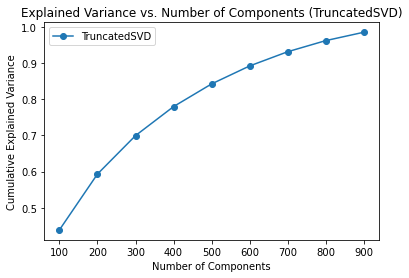

In [14]:
# This is used to find the optimal number of compononents for PCA and LSA
n_components_range = range(100, 1000, 100)

# Initialize lists to store explained variance ratios
#explained_variances_pca = []
explained_variances_lsa = []

# Fit PCA and TruncatedSVD for each value of n_components
for n_components in n_components_range:
    #pca = PCA(n_components=n_components)
    lsa = TruncatedSVD(n_components=n_components)
    
    #pca.fit(dense_array)
    lsa.fit(dense_array)
    
    #explained_variances_pca.append(sum(pca.explained_variance_ratio_))
    explained_variances_lsa.append(sum(lsa.explained_variance_ratio_))

# Plot the explained variance ratios for PCA
#plt.plot(n_components_range, explained_variances_pca, marker='o', label='PCA')
#plt.xlabel('Number of Components')
#plt.ylabel('Cumulative Explained Variance')
#plt.title('Explained Variance vs. Number of Components (PCA)')
#plt.legend()
#plt.show()

# Plot the explained variance ratios for TruncatedSVD (LSA)
plt.plot(n_components_range, explained_variances_lsa, marker='o', label='TruncatedSVD')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components (TruncatedSVD)')
plt.legend()
plt.show()


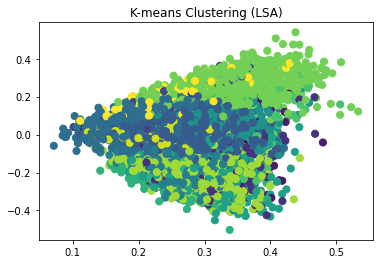

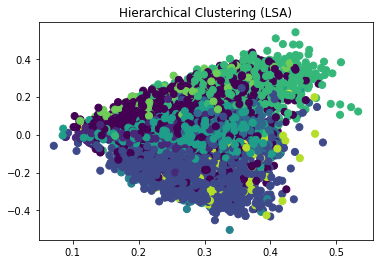

In [15]:

#pca = PCA(n_components=10)  
#X_pca = pca.fit_transform(dense_array)

lsa = TruncatedSVD(n_components=500)  # You can adjust the number of components
X_lsa = lsa.fit_transform(dense_array)

# Model selection using K-means clustering
kmeans = KMeans(n_clusters=15)  
#kmeans_labels_pca = kmeans.fit_predict(X_pca)  
kmeans_labels_lsa = kmeans.fit_predict(X_lsa) 

# Model selection using Hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=10, linkage='ward')  
#hierarchical_labels_pca = hierarchical.fit_predict(X_pca)  
hierarchical_labels_lsa = hierarchical.fit_predict(X_lsa)


#K-means - LSA
plt.scatter(X_lsa[:, 0], X_lsa[:, 1], c=kmeans_labels_lsa, cmap='viridis', s=50)
plt.title('K-means Clustering (LSA)')
plt.show()

#HC - lsa
plt.scatter(X_lsa[:, 0], X_lsa[:, 1], c=hierarchical_labels_lsa, cmap='viridis', s=50)
plt.title('Hierarchical Clustering (LSA)')
plt.show()


Unique Labels in DBSCAN:
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12]


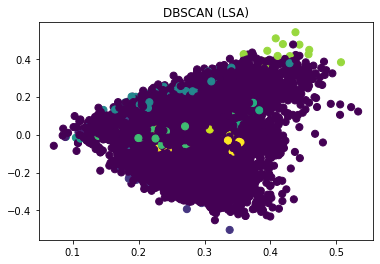

In [16]:
# DBSCAN clustering
dbscan_eps = 0.75
dbscan_min_samples = 12
dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
dbscan_labels = dbscan.fit_predict(X_lsa)

unique_labels = np.unique(dbscan_labels)

# Display unique labels
print("Unique Labels in DBSCAN:")
print(unique_labels)

#DBSCAN - lsa
plt.scatter(X_lsa[:, 0], X_lsa[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title('DBSCAN (LSA)')
plt.show()

In [17]:
# Feel free to Adjust the number of common words to display
# Function to display most relevant words in each cluster
def display_cluster_words(labels, abstracts):
    cluster_words = defaultdict(list)
    for i, label in enumerate(labels):
        abstract = abstracts[i]
        words = abstract.lower().split()  # Basic tokenization, adjust as needed
        cluster_words[label].extend(words)

    # Display the most common words in each cluster
    for label, words in cluster_words.items():
        common_words = [word for word, count in Counter(words).most_common(15)] 
        print(f"Cluster {label}: Most Common Words - {common_words}")

abstracts_column = 'processed_abstract'
abstracts = df[abstracts_column].tolist()
# Display most relevant words for each clustering algorithm
print("DBSCAN Cluster Words:")
display_cluster_words(dbscan_labels, abstracts)

print("\nKMeans Cluster Words:")
display_cluster_words(kmeans_labels_lsa, abstracts)

print("\nHierarchical Cluster Words:")
display_cluster_words(hierarchical_labels_lsa, abstracts)


DBSCAN Cluster Words:
Cluster -1: Most Common Words - ['use', 'social', 'studi', 'media', 'time', 'associ', 'children', 'screen', 'smartphon', 'activ', 'result', 'phone', 'adolesc', 'behavior', 'health']
Cluster 3: Most Common Words - ['myopia', 'time', 'p', 'factor', 'risk', 'children', 'associ', 'screen', 'studi', 'parent', 'use', 'preval', 'school', 'student', 'ci']
Cluster 0: Most Common Words - ['pedestrian', 'cross', 'use', 'distract', 'phone', 'mobil', 'traffic', 'safeti', 'behavior', 'studi', 'time', 'result', 'road', 'behaviour', 'intersect']
Cluster 5: Most Common Words - ['polit', 'media', 'social', 'use', 'news', 'particip', 'studi', 'inform', 'onlin', 'effect', 'knowledg', 'find', 'engag', 'differ', 'activ']
Cluster 10: Most Common Words - ['social', 'media', 'use', 'studi', 'find', 'research', 'disast', 'effect', 'lgbt', 'pr', 'user', 'inform', 'present', 'literatur', 'examin']
Cluster 1: Most Common Words - ['guidelin', 'meet', 'movement', 'sleep', 'physic', 'activ', 'ti

In [18]:
def find_most_common_keywords(labels, abstracts, keywords):
    cluster_keywords = defaultdict(list)

    for i, label in enumerate(labels):
        abstract = abstracts[i]
        keyword_list = keywords[i].split(",")  # Assuming keywords are separated by commas
        cluster_keywords[label].extend(keyword_list)

    # Display the most common keywords in each cluster
    for label, keywords_list in cluster_keywords.items():
        counter = Counter(keywords_list)
        most_common_keywords = counter.most_common(10)  # Adjust the number based on your preference
        print(f"Cluster {label}: Most Common Keywords - {most_common_keywords}")

In [ ]:
from collections import defaultdict, Counter

def find_most_common_keywords(labels, abstracts, keywords):
    cluster_keywords = defaultdict(list)

    for i, label in enumerate(labels):
        abstract = abstracts[i]
        keyword_list = keywords[i].split(";")  # Splitting keywords on semi-colons
        cluster_keywords[label].extend(keyword_list)

    # Display the most common keywords in each cluster
    for label, keywords_list in cluster_keywords.items():
        counter = Counter(keywords_list)
        most_common_keywords = counter.most_common(20)  # Adjust the number based on your preference
        print(f"Cluster {label}: Most Common Keywords - {most_common_keywords}")

# Assuming keywords_column is the name of the column containing keywords
keywords_column = 'keywords'
keywords = df[keywords_column].tolist()

# Assuming you have labels and abstracts as well
labels = df['labels'].tolist()
abstracts = df['abstracts'].tolist()

# Call the function
find_most_common_keywords(labels, abstracts, keywords)


In [19]:
keywords_column = 'keywords'
keywords = df[keywords_column].tolist()

In [20]:
print("DBSCAN Most Common Keywords:")
find_most_common_keywords(dbscan_labels, abstracts, keywords)

DBSCAN Most Common Keywords:
Cluster -1: Most Common Keywords - [('sedentary behaviour; recommendations; infants; toddlers; preschoolers', 4), ('Psychopathology; Mental disorders; Information technology; Mobile phones; Addictions; Internet addiction', 3), ('smartphone; addiction; validity; reliability', 3), ('scoping review; social media; mental health; adolescence; well-being', 2), ('Psychology', 2), ('Media; Technology; III-being; Health; Video gaming; Screen time; Children; Preteens; Teenagers; Physical activity; Exercise; Electronic communication; Television; Obesity; Attention; Food consumption', 2), ('Personal tracking; Multi-device Use; Software Trial; Qualitative Interviews; Lived Informatics; Design', 2), ('Parent support behaviours; Child obesity; Physical activity; Healthy eating; Screen time', 2), ('Depression; Anxiety; Physical activity; Screen time; Sedentary behavior; Longitudinal; Bidirectional; Reciprocal; Adolescence', 2), ('Television; Digital media; Mobile device; S

In [21]:
print("\nKMeans Most Common Keywords:")
find_most_common_keywords(kmeans_labels_lsa, abstracts, keywords)


KMeans Most Common Keywords:
Cluster 5: Most Common Keywords - [('Personal tracking; Multi-device Use; Software Trial; Qualitative Interviews; Lived Informatics; Design', 2), ('Consumer innovativeness; context-based marketing; push recommendation; smartphones; travel applications', 2), ('excessive Internet use; mobile devices; adolescents; online games; social networking sites; Europe', 2), ('Mobile phone; Psychopathological symptoms; Unintentional injuries; Interaction; Adolescents', 2), ('Mobile phone; posture; muscle activity; surface electromyography; ergonomics', 2), ('consumer behavior; fantasy sport; sport consumption; social networking; identity', 2), ('Smartphone; Human mobility; Prediction; Personalized service', 2), ('Gait; Cognitive-motor interference; Attention; Prioritization; Texting', 2), ('cancer epidemiology; brain cancer; trends; mobile phones', 2), ('Dual-task; Texting; Situational awareness; Gait kinematics; Attention', 2)]
Cluster 11: Most Common Keywords - [('in

In [22]:
print("\nHierarchical Most Common Keywords:")
find_most_common_keywords(hierarchical_labels_lsa, abstracts, keywords)


Hierarchical Most Common Keywords:
Cluster 0: Most Common Keywords - [('Media; Technology; III-being; Health; Video gaming; Screen time; Children; Preteens; Teenagers; Physical activity; Exercise; Electronic communication; Television; Obesity; Attention; Food consumption', 2), ('Personal tracking; Multi-device Use; Software Trial; Qualitative Interviews; Lived Informatics; Design', 2), ('Consumer innovativeness; context-based marketing; push recommendation; smartphones; travel applications', 2), ('excessive Internet use; mobile devices; adolescents; online games; social networking sites; Europe', 2), ('Adolescents; Mental health; Sedentary behaviour; Screen time', 2), ('Sedentary; Screen time; Mental health; Birth cohort', 2), ('Depressive symptomatology; adolescents; diet pattern; physical activity; screen time', 2), ('Job demands-resources; Cell phones; Work-family; Emotional exhaustion; Work engagement', 2), ('boundary management; diary study; family role performance; smartphone us

In [23]:
def find_intersection_of_keywords(labels, abstracts, keywords):
    cluster_keywords = defaultdict(list)

    for i, label in enumerate(labels):
        abstract = abstracts[i]
        keyword_list = keywords[i].split(",")  # Assuming keywords are separated by commas
        cluster_keywords[label].append(set(keyword_list))

    # Display the intersection of keywords in each cluster
    for label, keywords_set_list in cluster_keywords.items():
        common_keywords = set.intersection(*keywords_set_list) if len(keywords_set_list) > 1 else set()
        print(f"Cluster {label}: Intersection of Keywords - {common_keywords}")


In [24]:
find_intersection_of_keywords(dbscan_labels, abstracts, keywords)

Cluster -1: Intersection of Keywords - set()
Cluster 3: Intersection of Keywords - set()
Cluster 0: Intersection of Keywords - set()
Cluster 5: Intersection of Keywords - set()
Cluster 10: Intersection of Keywords - set()
Cluster 1: Intersection of Keywords - set()
Cluster 7: Intersection of Keywords - set()
Cluster 2: Intersection of Keywords - set()
Cluster 4: Intersection of Keywords - set()
Cluster 11: Intersection of Keywords - set()
Cluster 8: Intersection of Keywords - set()
Cluster 6: Intersection of Keywords - set()
Cluster 9: Intersection of Keywords - set()
Cluster 12: Intersection of Keywords - set()


In [25]:
find_intersection_of_keywords(kmeans_labels_lsa, abstracts, keywords)

Cluster 5: Intersection of Keywords - set()
Cluster 11: Intersection of Keywords - set()
Cluster 7: Intersection of Keywords - set()
Cluster 8: Intersection of Keywords - set()
Cluster 6: Intersection of Keywords - set()
Cluster 13: Intersection of Keywords - set()
Cluster 1: Intersection of Keywords - set()
Cluster 12: Intersection of Keywords - set()
Cluster 0: Intersection of Keywords - set()
Cluster 3: Intersection of Keywords - set()
Cluster 10: Intersection of Keywords - set()
Cluster 4: Intersection of Keywords - set()
Cluster 9: Intersection of Keywords - set()
Cluster 14: Intersection of Keywords - set()
Cluster 2: Intersection of Keywords - set()


In [26]:
# Now we calculate a set of metrics and visualisation techniques to see which feature extraction/clustering 
# method has the best performance. I chose the most widely used and effective

#Evaluation Metrics

inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

# Silhouette Score

silhouette_2 = silhouette_score(dense_array, kmeans_labels_lsa)
print(f"Silhouette Score K-means LSA: {silhouette_2}")


silhouette_4 = silhouette_score(dense_array, hierarchical_labels_lsa)
print(f"Silhouette Score Hierarchical clustering LSA: {silhouette_4}")

# Calinski-Harabasz Index

calinski_harabasz2 = calinski_harabasz_score(dense_array, kmeans_labels_lsa)
print(f"Calinski-Harabasz Index K-means PCA : {calinski_harabasz2}")

# Davies-Bouldin Index

davies_bouldin2 = davies_bouldin_score(dense_array, kmeans_labels_lsa)
print(f"Davies-Bouldin Index: {davies_bouldin2}")


Inertia: 4317.047359812141
Silhouette Score K-means LSA: 0.03239851205819393
Silhouette Score Hierarchical clustering LSA: 0.006229100872213184
Calinski-Harabasz Index K-means PCA : 63.013400301618844
Davies-Bouldin Index: 4.706760334987053


In [27]:
#THE lables are now added in the dataset
#df['k_pca'] = kmeans_labels_pca
#df['hc_pca'] = hierarchical_labels_pca

df['k_lsa'] = kmeans_labels_lsa
df['hc_lsa'] = hierarchical_labels_lsa
df['db_lsa'] = dbscan_labels

In [28]:
#Run only after everything is finalised.
# Save the DataFrame with clustering labels
df.to_csv('dataset_with_labels.csv', index=False)

# The code below is for BERT 
## Do not run this on your laptop use COLAB 

In [ ]:
abstracts_column = 'processed_abstract'
abstracts = df[abstracts_column].tolist()

# Tokenization using BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_inputs = tokenizer(abstracts, padding=True, truncation=True, return_tensors='pt')

# Model initialization
model = BertModel.from_pretrained('bert-base-uncased')

# Obtain BERT embeddings
with torch.no_grad():
    model.eval()
    outputs = model(**tokenized_inputs)

# Extract embeddings from the last layer
embeddings = outputs.last_hidden_state[:, 0, :].numpy()

num_components = 1000  # Adjust based on your choice
lsa = TruncatedSVD(n_components=num_components, random_state=42)
embeddings = lsa.fit_transform(embeddings)

# Combine BERT embeddings with TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(abstracts)
combined_embeddings = np.hstack((embeddings, tfidf_matrix.toarray()))

# DBSCAN clustering
eps_value = 2  # Adjust based on your choice
min_samples_value = 10  # Adjust based on your choice
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
cluster_labels = dbscan.fit_predict(combined_embeddings)

# Extract relevant words for each cluster
cluster_words = defaultdict(list)
for i, label in enumerate(cluster_labels):
    abstract = abstracts[i]
    words = abstract.lower().split()  # Basic tokenization, adjust as needed
    cluster_words[label].extend(words)

# Display the most common words in each cluster
for label, words in cluster_words.items():
    common_words = [word for word, count in Counter(words).most_common(10)]  # Adjust the number of words to display
    print(f"Cluster {label}: Most Common Words - {common_words}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

# Do not Run
## Not relevant

In [ ]:
# 2. Visualizations

# Display cluster profiles
cluster_profiles = df.groupby('k_pca').mean()

# Display top terms (features) for each cluster
for cluster in range(6):
    print(f"\nCluster {cluster + 1} Top Terms:")
    cluster_profile = cluster_profiles.loc[cluster]
    top_terms = cluster_profile.sort_values(ascending=False).index[:10]
    print(top_terms)

# Visualize cluster profiles using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)
plt.title('Cluster Profiles - Kmeans PCA')
plt.show()


# Dendrogram for Hierarchical Clustering
plt.figure(figsize=(15,8))
linkage_matrix = linkage(dense_array, method='ward')
dendrogram(linkage_matrix)
plt.title('Dendrogram for Hierarchical Clustering')
plt.show()


In [ ]:
#Do not run
# Save the DataFrame with clustering labels
df.to_csv('dataset_with_labels.csv', index=False)

#Interpretation of scores and selection of best model 

Inertia is the sum of squared distances between data points and their assigned cluster centroids. A lower inertia is generally better. 

Silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The scores range from -1 to 1, with higher values indicating better-defined clusters.

The Calinski-Harabasz Index measures the ratio of between-cluster variance to within-cluster variance. Higher values indicate better-defined clusters.

The Davies-Bouldin Index measures the compactness and separation of clusters. Lower values indicate better clustering.

I tried many combinations of PCA/LSA features, number of clusters and the best results are as follows. 

1. A combination of  K-means with 10 clusters and LSA with 10 componenets 
2. A combination of Hierarchical with 10 clusters and LSA with 10 componenets 

you can open the csv file generated above and sort according to the labels to see how well the clustering works. FYI it's actually quite good. 

In [ ]:
#Do not run

# Model selection using LDA
lda = LatentDirichletAllocation(n_components=6, random_state=42)  # You can adjust the number of components
lda.fit(X)
lda_labels_pca = lda.transform(X_pca).argmax(axis=1)
lda_labels_lca = lda.transform(X_lca).argmax(axis=1)

The Abstract analysis notebook was designed to extract relevant information from a dataset containing abstracts of research papers and categorize them based on similarity. 
I used a dataset containing the abstarcts of 90 papers. If you remember that is the total number of papers you thought were relevant and sent it to me and I went through their abstracts and categorized them based on their relevance. 

The steps involved are briefly explained. 

(Natural Language Processing Techniques)
1. Perform text preprocessing 

Tokenization: Break down each abstract into individual words or subwords.
Lowercasing: Convert all words to lowercase to ensure uniformity.
Removing Stop Words: Eliminate common words that don't contribute much to the overall meaning.
Lemmatization or Stemming: Reduce words to their base or root form.

2. Vectorization:

Convert the preprocessed text into numerical vectors. I use TF-IDF

3. Feature extraction and model training 

Extract relevant features from the vectorized data. I use  Principal Component Analysis (PCA) and Latent Semantic Analysis (LSA). For models i use K-means and hierarchical clustering. They are the two most widely used models with the capability to scale for huge amounts of data. 

4. Find the optimal parameters using trial and error(hyperparameter tuning)

5. Use evaluation and visualisation techniques to find best combination of model/feature extractions. 


In [ ]:
# Visualize results for Hierarchical clustering
#HC - PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels_pca, cmap='viridis', s=50)
plt.title('Hierarchical Clustering (PCA)')
plt.show()

# Visualize results for K-means
#K-means - PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels_pca, cmap='viridis', s=50)
plt.title('K-means Clustering (PCA)')
plt.show()

silhouette_1 = silhouette_score(dense_array, kmeans_labels_pca)
print(f"Silhouette Score K-means PCA: {silhouette_1}")

silhouette_3 = silhouette_score(dense_array, hierarchical_labels_pca)
print(f"Silhouette Score Hierarchical clustering PCA: {silhouette_3}")

calinski_harabasz1 = calinski_harabasz_score(dense_array, kmeans_labels_pca)
print(f"Calinski-Harabasz Index K-means PCA : {calinski_harabasz1}")

davies_bouldin1 = davies_bouldin_score(dense_array, kmeans_labels_pca)
print(f"Davies-Bouldin Index: {davies_bouldin1}")
